# Virtual screening workflow using de-novo design 

The goal of  this virtual screening workflow is to find out putative inhibitors of EGFR.

In [131]:
import os
import sys
import pandas as pd
import numpy as np
import pprint
import itertools

import mols2grid
import prolif as plf
import py3Dmol
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import Draw, PandasTools, Descriptors, DataStructs
from rdkit.Chem.Descriptors import qed
import datamol as dm
import medchem as mc
from moleval.metrics.metrics import GetMetrics
import py3Dmol

import seaborn as sns
import matplotlib.pyplot as plt


import umap

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

from utils import CreateProlifFingerPrint, get_scaffold, create_list_of_molecules, calculate_tanimoto_similarities, generate_molecules

## Seed molecules

35 small molecules for target EGFR were obtained from ChEMBL. These molecules are either FDA approved molecules or molecules in clinical trials (phase 2 and 3).These molecules are going to be used as seeds for de novo generation of new molecules.

In [2]:
mols2grid.display("data/egfr_chembl.sdf", size=(300, 300))

MolGridWidget()

In [3]:
list_of_seed_molecules = [Chem.MolToSmiles(x) for x in create_list_of_molecules("data/egfr_chembl.sdf")]


# De novo molecule generation

## Molmim

Molmim by Nvidia is used in this workflow to generate new molecules using the seeds. Molmim has a variational autoencoder based approach. Molnin is available via the Bionemo platform. In the enterprise version, first time user gets 1000 free API tokens. But users can use the web service and generates molecules. 
12 molecules were generated for each seeds with minimum 0.6 tanimoto similarity and QED was used to optimize the property. Total 399 unique molecules were generated.


In [14]:
molmim_df = PandasTools.LoadSDF("data/first_gen/processed.sdf")

In [15]:
molmim_df["canonical_smiles"] = molmim_df["ROMol"].apply(lambda x: Chem.MolToSmiles(x))

In [16]:
list_of_molmim_smiles = molmim_df.canonical_smiles.to_list()

In [17]:
MetricEngine = GetMetrics(
    n_jobs=1,
    device='cpu',
    batch_size=512,
)
metrics = MetricEngine.calculate(
    list_of_molmim_smiles,
    calc_valid=True,
    calc_unique=True,
    unique_k=10000,
    se_k=1000,
    sp_k=1000,
    properties=True,
)

Cleaning up reference smiles


c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:205: UserWarning: Less than 1000 molecules so SEDiv is non-standard.
  warnings.warn(f'Less than {se_k} molecules so SEDiv is non-standard.')
c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:211: UserWarning: Less than 1000 molecules so SPDiv is non-standard.
  warnings.warn(f'Less than {sp_k} molecules so SPDiv is non-standard.')


### Metrics

In [18]:
pprint.pprint(metrics)

{'#': 399,
 '# scaffolds': 303,
 '# valid': 399,
 '# valid & unique': 399,
 'FG': 0.04714959279897128,
 'Filters': 0.681704260651629,
 'IntDiv1': 0.8278673972443484,
 'IntDiv2': 0.8107300377279317,
 'Purchasable_ZINC20': 0.005012531328320802,
 'RS': 0.09210526315789473,
 'SEDiv': 0.3057644110275689,
 'SPDiv': 0.8957775814832776,
 'ScaffDiv': 0.8014808411673983,
 'ScaffUniqueness': 0.7593984962406015,
 'Uniqueness': 1.0,
 'Validity': 1.0}


### Quality of the generated molecules

In [19]:
molmim_df["molwt"] = molmim_df["ROMol"].apply(lambda x: Descriptors.ExactMolWt(x))
molmim_df["qed"] = molmim_df["ROMol"].apply(lambda x: Descriptors.qed(x))

molmim_df["Tanimoto_Score"] = molmim_df["canonical_smiles"].apply(lambda smiles: np.max(calculate_tanimoto_similarities(smiles, list_of_seed_molecules)))

<Axes: >

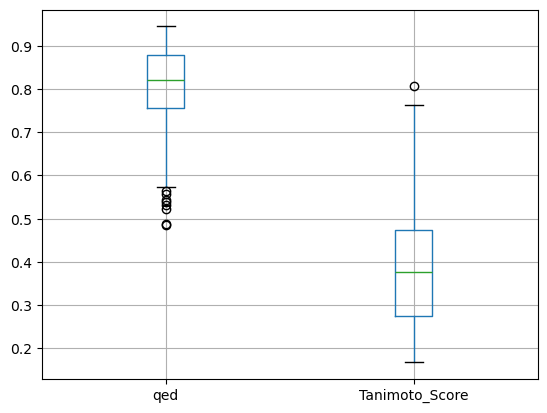

In [20]:
molmim_df.boxplot(column=["qed", "Tanimoto_Score"])



## CREM

In [55]:
molecules_list = []
for smi in list_of_seed_molecules:
    molecules_list.append(generate_molecules(smi))
flat_molecules_list = list(itertools.chain(*molecules_list))

In [56]:
crem_df = pd.DataFrame(flat_molecules_list, columns=["smiles"])

In [57]:
crem_df["ROMol"] = crem_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [58]:
crem_df.drop_duplicates(inplace=True)
crem_df.dropna(inplace=True)


In [59]:
crem_df.shape

(525, 2)

In [64]:
crem_df["molwt"] = crem_df["ROMol"].apply(lambda x: Descriptors.ExactMolWt(x))
crem_df["qed"] = crem_df["ROMol"].apply(lambda x: Descriptors.qed(x))

crem_df["Tanimoto_Score"] = crem_df["smiles"].apply(lambda smiles: np.max(calculate_tanimoto_similarities(smiles, list_of_seed_molecules)))

In [68]:
crem_df.head()

,smiles,ROMol,molwt,qed,Tanimoto_Score
0,CCCCNC(=O)N1CCC(Oc2cc3c(Nc4cc(I)cc(Cl)c4F)ncnc...,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,627.090944,0.177505,0.568182
1,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1OC1CCN(C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,515.209946,0.395496,0.695122
2,CCCCNC(=O)N1CCC(Oc2cc3c(Nc4cccc(Cl)c4F)ncnc3cc...,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,533.200524,0.316969,0.609195
3,CCCCNC(=O)N1CCC(Oc2cc3c(Nc4cccc(Cl)c4F)nc(SC)n...,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,547.182017,0.185848,0.566667
4,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1OC1CCN(C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,531.204860,0.319515,0.695122


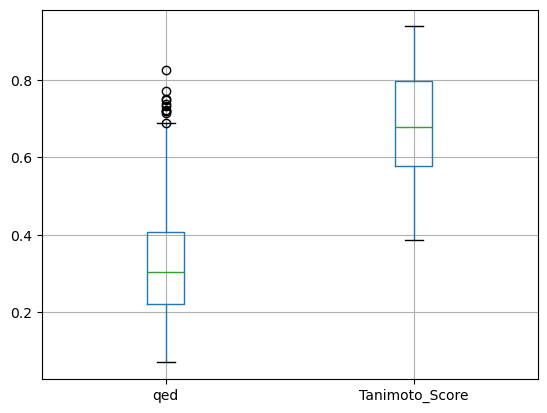

In [69]:
crem_df.boxplot(column=["qed", "Tanimoto_Score"])
plt.show()

In [70]:
list_of_crem_smiles = crem_df.smiles.to_list()

In [71]:
MetricEngine = GetMetrics(
    n_jobs=1,
    device='cpu',
    batch_size=512,
)
metrics = MetricEngine.calculate(
    list_of_crem_smiles,
    calc_valid=True,
    calc_unique=True,
    unique_k=10000,
    se_k=1000,
    sp_k=1000,
    properties=True,
)

Cleaning up reference smiles


c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:205: UserWarning: Less than 1000 molecules so SEDiv is non-standard.
  warnings.warn(f'Less than {se_k} molecules so SEDiv is non-standard.')
c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:211: UserWarning: Less than 1000 molecules so SPDiv is non-standard.
  warnings.warn(f'Less than {sp_k} molecules so SPDiv is non-standard.')


In [72]:
metrics

{'#': 525,
 'Validity': 1.0,
 '# valid': 525,
 'Uniqueness': 0.9085714285714286,
 '# valid & unique': 477,
 'IntDiv1': 0.7742349879900912,
 'IntDiv2': 0.7500386552996765,
 'SEDiv': 0.06079664570230608,
 'SPDiv': 0.6576192080510062,
 '# scaffolds': 156,
 'ScaffDiv': 0.7595544349669157,
 'ScaffUniqueness': 0.3270440251572327,
 'FG': 0.027901524032825323,
 'RS': 0.026615969581749048,
 'Filters': 0.10482180293501048,
 'Purchasable_ZINC20': 0.0}

## Removal of structural alerts and complex molecules

Rules used by the Novartis Institutes for BioMedical Research to build their screening deck were used to filter the molecules.

In [73]:
nibr_filters = mc.structural.NIBRFilters()


In [74]:
crem_df = nibr_filters(
    mols=crem_df["ROMol"].tolist(),
    n_jobs=-1,
    progress=True,
    progress_leave=True,
    scheduler="threads",
    keep_details=True,
)

crem_df.head(30)

NIBR filtering:   0%|          | 0/525 [00:00<?, ?it/s]

,mol,reasons,severity,status,n_covalent_motif,special_mol,pass_filter,details
0,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); elements_penaliz...,2,flag,0,4,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
1,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
2,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
3,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
4,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); long_chain_flexi...,0,annotations,0,2,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
5,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); halogen_aromatic...,1,flag,0,3,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
6,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
7,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); halogen_aromatic...,1,flag,0,3,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
8,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); hydroquinone_min(1),10,exclude,0,2,False,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
9,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); halogen_alkyl_mi...,1,flag,1,3,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."


In [75]:
crem_df["pass_filter"].value_counts()

pass_filter
True     489
False     36
Name: count, dtype: int64

Three molecules were removed using this filters. The molecules are showing below.

In [76]:
fail_df = crem_df.query("pass_filter == False")
fail_df

,mol,reasons,severity,status,n_covalent_motif,special_mol,pass_filter,details
8,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); hydroquinone_min(1),10,exclude,0,2,False,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
47,<rdkit.Chem.rdchem.Mol object at 0x00000281E46...,catechole_min(1),10,exclude,1,1,False,"[{'name': 'catechole_min(1)', 'severity': 2, '..."
91,<rdkit.Chem.rdchem.Mol object at 0x00000281E43...,hydroquinone_min(1),10,exclude,0,1,False,"[{'name': 'hydroquinone_min(1)', 'severity': 2..."
136,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,hydroquinone_min(1); michael_acceptor_CH2_term...,10,exclude,1,2,False,"[{'name': 'hydroquinone_min(1)', 'severity': 2..."
139,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); amide_acyclic_co...,10,exclude,1,7,False,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
156,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); catechole_min(1),10,exclude,1,2,False,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
158,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); catechole_min(1),10,exclude,1,2,False,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
172,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); catechole_min(1),10,exclude,1,2,False,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
174,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); catechole_min(1),10,exclude,1,2,False,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev..."
204,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,catechole_min(1),10,exclude,1,1,False,"[{'name': 'catechole_min(1)', 'severity': 2, '..."


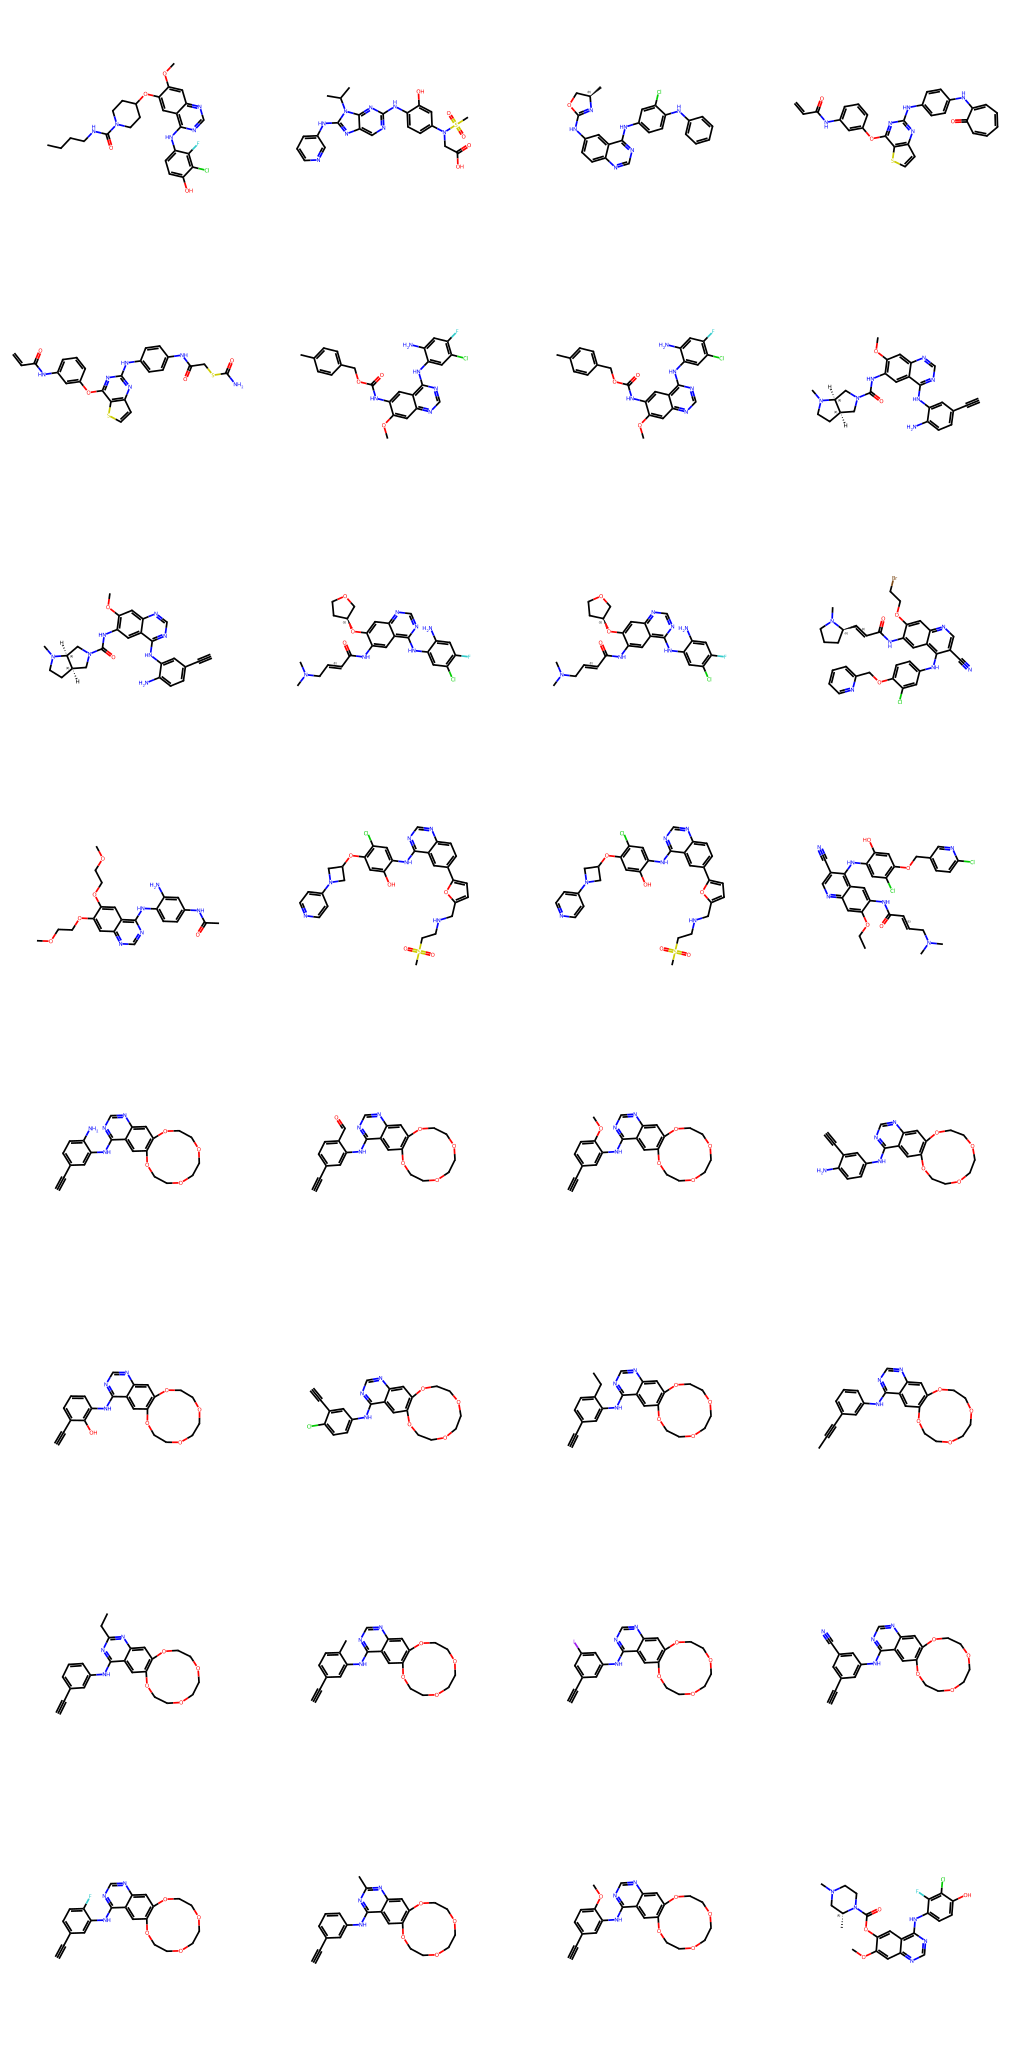

In [77]:
dm.to_image(fail_df["mol"].to_list())

## Complexity filter

I have also used another filter called "complexity filter" that applies an inutuitive metric for molecular complexitiy to exclude complex or difficult to synthesize molecules. . In this approach complexity is the sum of four terms: 4 times the number of rings, 2 times the number of nonaromatic unsaturations, 1 times the number of heteratoms, and 2 times the number of chiral centers. 

In [78]:
cfilter = mc.complexity.ComplexityFilter(threshold_stats_file="zinc_12", complexity_metric="whitlock")

cfilter.complexity_metric

'whitlock'

In [79]:
crem_df["pass_cfilter"] = crem_df["mol"].apply(cfilter)

crem_df["pass_cfilter"].value_counts()

pass_cfilter
True     496
False     29
Name: count, dtype: int64

This filter excluded 32 molecules

In [80]:
crem_df.head()

,mol,reasons,severity,status,n_covalent_motif,special_mol,pass_filter,details,pass_cfilter
0,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); elements_penaliz...,2,flag,0,4,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",True
1,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",True
2,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",True
3,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",True
4,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); long_chain_flexi...,0,annotations,0,2,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",True


In [81]:
complex_df = crem_df.query("pass_cfilter == False")

In [82]:
complex_df.head(30)

,mol,reasons,severity,status,n_covalent_motif,special_mol,pass_filter,details,pass_cfilter
18,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,nitro_count_1_min(1),0,annotations,0,1,True,"[{'name': 'nitro_count_1_min(1)', 'severity': ...",False
27,<rdkit.Chem.rdchem.Mol object at 0x00000281E46...,None,0,ok,0,0,True,NaN,False
72,<rdkit.Chem.rdchem.Mol object at 0x00000281E43...,michael_acceptor_CH2_terminal_min(1),0,annotations,1,1,True,[{'name': 'michael_acceptor_CH2_terminal_min(1...,False
165,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",False
166,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",False
167,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",False
168,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",False
169,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1); aldehyde_aromati...,0,annotations,1,2,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",False
170,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",False
171,<rdkit.Chem.rdchem.Mol object at 0x00000281E42...,acetal_aminal_acyclic_min(1),0,annotations,0,1,True,"[{'name': 'acetal_aminal_acyclic_min(1)', 'sev...",False


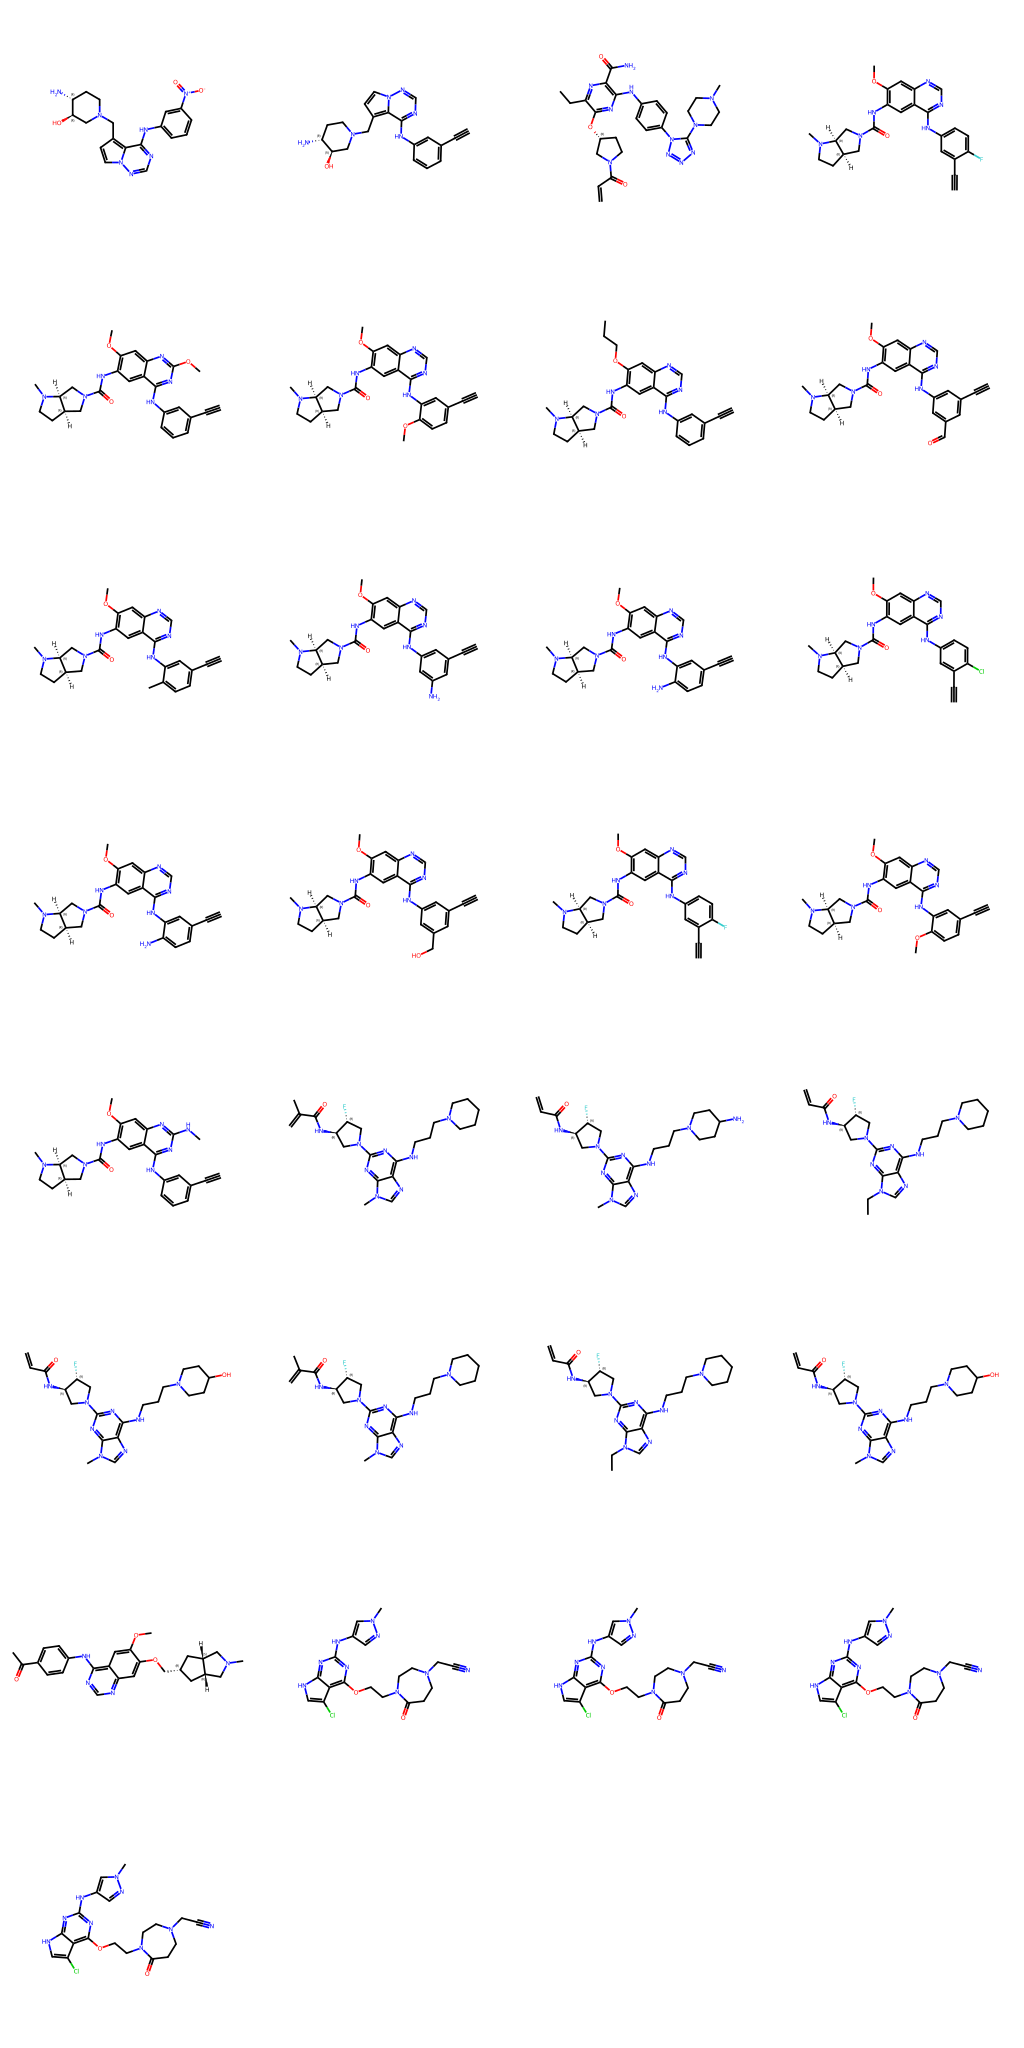

In [83]:
dm.to_image(complex_df["mol"].to_list())

I removed all the molecules that did not pass in those filters 

In [84]:
crem_processed = crem_df.query("pass_filter == True & pass_cfilter == True")

In [85]:
crem_processed.shape

(462, 9)

I also decided to keep the molecules that satisfies to Lipnisk's rule of 5. 

In [86]:
crem_processed["MolWt"] = crem_processed["mol"].apply(Descriptors.ExactMolWt)
crem_processed["LogP"] = crem_processed["mol"].apply(Descriptors.MolLogP)
crem_processed["NumHDonors"] = crem_processed["mol"].apply(Descriptors.NumHDonors)
crem_processed["NumHAcceptors"] = crem_processed["mol"].apply(Descriptors.NumHAcceptors)

C:\Users\abhik\AppData\Local\Temp\ipykernel_19392\4082179957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crem_processed["MolWt"] = crem_processed["mol"].apply(Descriptors.ExactMolWt)
C:\Users\abhik\AppData\Local\Temp\ipykernel_19392\4082179957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crem_processed["LogP"] = crem_processed["mol"].apply(Descriptors.MolLogP)
C:\Users\abhik\AppData\Local\Temp\ipykernel_19392\4082179957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [87]:
crem_processed = crem_processed.query("MolWt > 160 & MolWt < 500 & LogP < 5 &  NumHDonors < 5 & NumHAcceptors < 10")

In [88]:
crem_processed.shape

(108, 13)

352 molecules will be prepared for docking the next step.

# Docking

Next the filtered molecules were dockind using SMINA. I used crsytal structure EGFR with Gefitinib as the target structure and ligand Gefitinib IRE as reference. The docking protocol was validated by redocking Gefitinib in the crystal structure. PDB entry 2ITO was used as target structure. There are 4 structures avilable with Gefitinib. 2ITO was selected because the binding pocket is well resolved. 

In [89]:
!obabel "data/2ito_IRE.sdf" -O "data/IRE_processed.sdf" -p

1 molecule converted


In [90]:
!smina -r "data/2ito_processed.pdb" -l "data/IRE_processed.sdf" --autobox_ligand "data/2ito_IRE.sdf" --num_modes 1 -o "data/redocked_IRE.sdf"

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -827082328

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


In [91]:
view = py3Dmol.view()
view.addModel(open("data/2ito_processed.pdb","r").read(),format="pdb")
Prot=view.getModel()
Prot.setStyle({'cartoon':{'color':'white'}})

view.addModels(open("data/IRE_processed.sdf","r").read(),format="sdf")
ref_m = view.getModel()
ref_m.setStyle({'stick':{'colorscheme':'redCarbon','radius':0.2}})

view.addModels(open("data/redocked_IRE.sdf","r").read(),format="sdf")
ref_m = view.getModel()

ref_m.setStyle({'stick':{'colorscheme':'greenCarbon','radius':0.2}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Next filtered output of Molmim were docked in 2ITO using IRE as reference.

In [92]:
PandasTools.WriteSDF(crem_processed, "data/processed_crem_ligands.sdf", molColName="mol", properties=list(crem_processed.columns) )

In [93]:
!obabel "data/processed_crem_ligands.sdf" -O "data/processed_crem_ligands_obabel.sdf" -p

108 molecules converted


In [95]:
!smina -r "data/2ito_processed.pdb" -l "data/processed_crem_ligands_obabel.sdf" --autobox_ligand "data/2ito_IRE.sdf" --num_modes 1 -o "data/docked_crem_ligands.sdf" 

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 498186976

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1

In [96]:
!obabel "data/docked_crem_ligands.sdf" -O "data/docked_crem_ligands.sdf" -p

108 molecules converted


# Protein ligand fingerprint generation and filtering

These docked ligands were further rescored using protein ligand interaction fingerprint. Prolif library has been used for this purpose. Gefitinib bound structure of EGFR was used as reference.

In [97]:
fp_generator = CreateProlifFingerPrint(receptor_file="data/2ito_processed.pdb")

In [98]:
ref_fp = fp_generator.create_fingerprint_of_reference_ligand(sdf_file = "data/2ito_IRE.sdf", index = 0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [99]:
ref_fp

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x281e41229a0>

In [100]:
ref_df = ref_fp.to_dataframe(index_col="Pose")
ref_df.rename(index={0: -1}, inplace=True)
# set the ligand name to be the same as poses
ref_df.rename(columns={"reference": ref_df.columns.levels[0][0]}, inplace=True)

In [101]:
poses_fp = fp_generator.create_fingerprints_of_docking_poses(sdf_file="data/docked_crem_ligands.sdf")

  0%|          | 0/108 [00:00<?, ?it/s]

In [102]:
poses_df = poses_fp.to_dataframe(index_col=False)

In [103]:
df_ref_poses = (
    pd.concat([ref_df, poses_df])
    .fillna(False)
    .sort_index(
        axis=1,
        level=1,
        key=lambda index: [plf.ResidueId.from_string(x) for x in index],
    )
)

In [104]:
df_ref_poses.shape

(109, 80)

In [105]:
bitvectors = plf.to_bitvectors(df_ref_poses)
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors[1:])

In [106]:
result_df = PandasTools.LoadSDF("data/docked_crem_ligands.sdf")

In [107]:
result_df["plif_sim"] = tanimoto_sims

In [108]:
result_df["smiles"] = result_df["ROMol"].apply(lambda mol: Chem.MolToSmiles(mol))

In [109]:
result_df[ "QED" ] =  result_df.ROMol.apply( qed )

In [110]:
result_df["num_heavy_atoms"] = result_df["ROMol"].apply(lambda x: Chem.rdMolDescriptors.CalcNumHeavyAtoms(x))

In [111]:
result_df["LE"] = -(result_df["minimizedAffinity"].astype(float))/result_df["num_heavy_atoms"].astype(float)

In [112]:
import sascorer

In [113]:
result_df["sascore"] = result_df["ROMol"].apply(lambda mol: sascorer.calculateScore(mol))

In [114]:
result_df = result_df.astype({"minimizedAffinity": float})

In [115]:
result_df.head()

,minimizedAffinity,ID,ROMol,plif_sim,smiles,QED,num_heavy_atoms,LE,sascore
0,-9.00032,,<rdkit.Chem.rdchem.Mol object at 0x00000281E50...,0.272727,COc1cccc(NC(=O)Nc2ccc(CC[N@H+]3CCC([NH3+])C(O)...,0.488025,28,0.321440,4.238023
1,-8.75987,,<rdkit.Chem.rdchem.Mol object at 0x00000281E50...,0.538462,COc1cccc(Nc2ncnn3ccc(Cc4ccc(N)cc4)c23)c1,0.539906,26,0.336918,2.397194
2,-8.60315,,<rdkit.Chem.rdchem.Mol object at 0x00000281E50...,0.240000,COc1cccc(-c2csc(NC(=O)C[N@H+]3CCC([NH3+])C(O)C...,0.547315,25,0.344126,4.571683
3,-6.94274,,<rdkit.Chem.rdchem.Mol object at 0x00000281E50...,0.480000,CCOC(=O)CCCc1ccn2ncnc(Nc3cccc(OC)c3)c12,0.625072,26,0.267028,2.428505
4,-8.46616,,<rdkit.Chem.rdchem.Mol object at 0x00000281E50...,0.500000,COc1cccc(Nc2ncnn3ccc(CCn4ccc5ccccc54)c23)c1,0.462570,29,0.291937,2.516986


In [116]:
mols2grid.display(result_df, smiles_col="smiles")

MolGridWidget()

In [117]:
result_df.minimizedAffinity.astype(float).plot(kind="hist")

<Axes: ylabel='Frequency'>

In [118]:
result_df.QED.plot(kind="hist")

<Axes: ylabel='Frequency'>

In [119]:
result_df.LE.astype(float).plot(kind="hist")

<Axes: ylabel='Frequency'>

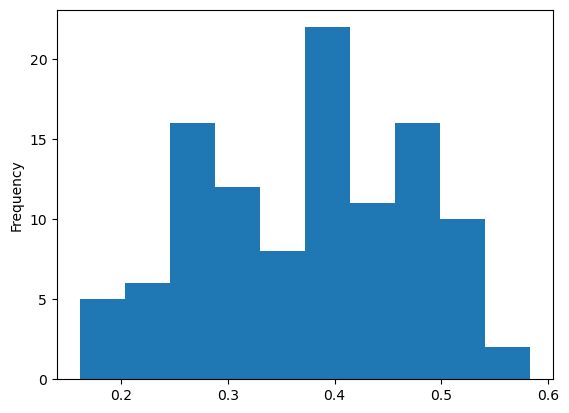

In [125]:
result_df.plif_sim.astype(float).plot(kind="hist")
plt.show()

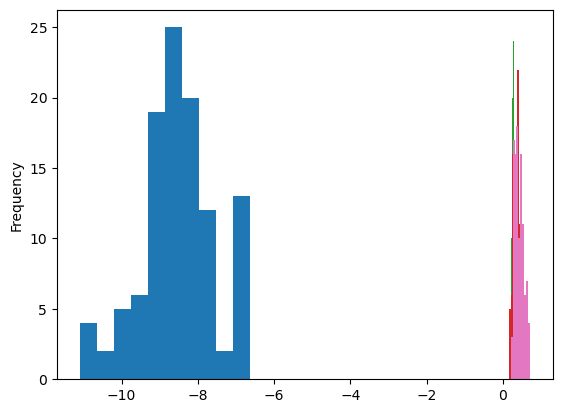

In [124]:
result_df.QED.astype(float).plot(kind="hist")
plt.show()

In [128]:
result_df_filtered = result_df.query("minimizedAffinity < -0.7 & plif_sim > 0.5")

In [129]:
result_df_filtered.shape

(6, 9)

In [130]:
mols2grid.display(result_df_filtered, smiles_col="smiles")

MolGridWidget()

In [254]:
PandasTools.WriteSDF(result_df_filtered, "data/top_hits.sdf")

Cleaning up reference smiles


c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:205: UserWarning: Less than 1000 molecules so SEDiv is non-standard.
  warnings.warn(f'Less than {se_k} molecules so SEDiv is non-standard.')
c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:211: UserWarning: Less than 1000 molecules so SPDiv is non-standard.
  warnings.warn(f'Less than {sp_k} molecules so SPDiv is non-standard.')


UMAP plotting

In [209]:
from rdkit.Chem import AllChem
from typing import List

def smiles_to_fp(smiles_series: pd.Series) -> List[AllChem.GetMorganFingerprintAsBitVect]:
    fingerprints = []
    for smile in smiles_series:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fingerprints.append(fp)
    return fingerprints

In [210]:
molmim_df["generation"] = "gen_1"

In [220]:
molmim_df.head()

,mol,pass_filter,reasons,severity,status,n_covalent_motif,special_mol,details,pass_cfilter,generation
0,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1
1,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1
2,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1
3,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1
4,<rdkit.Chem.rdchem.Mol object at 0x000001E5AB4...,True,None,0,ok,0,0,NaN,True,gen_1


In [221]:
molmim_df["canonical_smiles"] = molmim_df["mol"].apply(lambda x: Chem.MolToSmiles(x))

In [225]:
molmim_df.head()

,mol,pass_filter,reasons,severity,status,n_covalent_motif,special_mol,details,pass_cfilter,generation,canonical_smiles
0,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1,Fc1c(Cl)cccc1Nc1cc(N2CCOCC2)ncn1
1,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1,CN1CCN(c2cc(Nc3cccc(Cl)c3F)ncn2)CC1
2,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1,CC(=O)N1CCN(c2cc(Nc3cccc(Cl)c3F)ncn2)CC1
3,<rdkit.Chem.rdchem.Mol object at 0x000001E5A39...,True,None,0,ok,0,0,NaN,True,gen_1,CN1CCN(C(=O)c2nccnc2Nc2cccc(Cl)c2F)CC1
4,<rdkit.Chem.rdchem.Mol object at 0x000001E5AB4...,True,None,0,ok,0,0,NaN,True,gen_1,COc1c(Nc2cccc(Cl)c2F)ncnc1N1CCN(C)CC1


In [255]:
molmim_second_run = PandasTools.LoadSDF("data/second_gen/processed_2nd_gen.sdf")

In [256]:
molmim_second_run.head()

,ID,ROMol
0,,<rdkit.Chem.rdchem.Mol object at 0x000001E5AB8...
1,,<rdkit.Chem.rdchem.Mol object at 0x000001E5AB8...
2,,<rdkit.Chem.rdchem.Mol object at 0x000001E5AB8...
3,,<rdkit.Chem.rdchem.Mol object at 0x000001E5AB8...
4,,<rdkit.Chem.rdchem.Mol object at 0x000001E5AB8...


In [257]:
molmim_second_run["canonical_smiles"] = molmim_second_run["ROMol"].apply(lambda x: Chem.MolToSmiles(x))

In [258]:
molmim_second_run["generation"] = "gen_2"

In [212]:
chembl_df = PandasTools.LoadSDF("data/egfr_chembl.sdf")

In [213]:
chembl_df["canonical_smiles"] = chembl_df["ROMol"].apply(lambda x: Chem.MolToSmiles(x))

In [214]:
chembl_df["generation"] = "seeds"

In [259]:
final_df = pd.concat([molmim_df, molmim_second_run, chembl_df])

In [260]:
smiles_list = final_df.canonical_smiles.to_list()
generation_list = final_df.generation.to_list()

In [261]:
fps = smiles_to_fp(smiles_list)
        
fps_array = np.array(fps)
umap_reducer = umap.UMAP(n_neighbors=50, random_state=20)
umap_results = umap_reducer.fit_transform(fps_array)
umap_df = pd.DataFrame(umap_results, columns=["UMAP1", "UMAP2"])
umap_df["Source"] = [label for label, fp in zip(generation_list, fps) if fp is not None]

c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

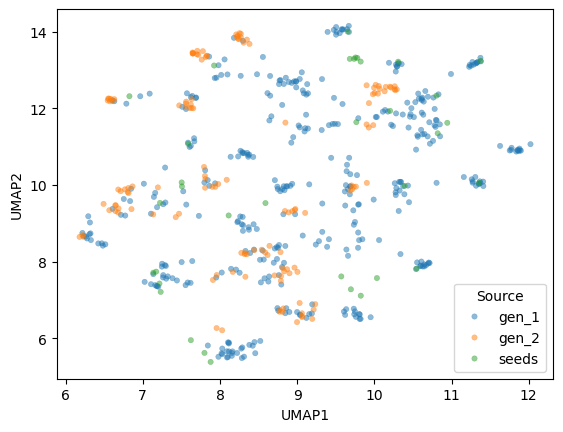

In [262]:
sns.scatterplot(
        data=umap_df,
        x="UMAP1",
        y="UMAP2",
        hue="Source",
        edgecolor=None,
        s=15,
        alpha=0.5,
        
    )